<a href="https://colab.research.google.com/github/rafiqmyura/Learn-Machine-Learning/blob/main/Disable_Sign_People_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras_cv

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import Callback
import keras_cv

BATCH_SIZE = 4
GLOBAL_CLIPNORM = 10.0

AUTO = tf.data.AUTOTUNE

Using TensorFlow backend


### Using Preprocessing with TensorFlow

In [4]:
def parse_txt_annot(img_path, txt_path):
    img = cv2.imread(img_path)
    w = int(img.shape[0])
    h = int(img.shape[1])

    file_label = open(txt_path, "r")
    lines = file_label.read().split('\n')

    boxes = []
    classes = []

    for i in range(0, int(len(lines))):
        objbud=lines[i].split(' ')
        class_ = int(objbud[0])

        x1 = float(objbud[1])
        y1 = float(objbud[2])
        w1 = float(objbud[3])
        h1 = float(objbud[4])

        xmin = int((x1*w) - (w1*w)/2.0)
        ymin = int((y1*h) - (h1*h)/2.0)
        xmax = int((x1*w) + (w1*w)/2.0)
        ymax = int((y1*h) + (h1*h)/2.0)

        boxes.append([xmin ,ymin ,xmax ,ymax])
        classes.append(class_)

    return img_path, classes, boxes


# a function for creating file paths list
def create_paths_list(path):
    full_path = []
    images = sorted(os.listdir(path))

    for i in images:
        full_path.append(os.path.join(path, i))

    return full_path


class_ids = ['apart_parking', 'blackbox', 'disabled_parking', 'etc', 'highpass', 'navigator']
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [5]:
def creating_files(img_files_paths, annot_files_paths):

    img_files = create_paths_list(img_files_paths)
    annot_files = create_paths_list(annot_files_paths)

    image_paths = []
    bbox = []
    classes = []

    for i in range(0,len(img_files)):
        image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i])
        image_paths.append(image_path_)
        bbox.append(bbox_)
        classes.append(classes_)

    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)

    return image_paths, classes, bbox

In [14]:
train_img_paths, train_classes, train_bboxes = creating_files ('/content/drive/MyDrive/Data Disable Detection/train/images', '/content/drive/MyDrive/Data Disable Detection/train/labels')

valid_img_paths, valid_classes, valid_bboxes = creating_files ('/content/drive/MyDrive/Data Disable Detection/valid/images', '/content/drive/MyDrive/Data Disable Detection/valid/labels')

test_img_paths, test_classes, test_bboxes = creating_files ('/content/drive/MyDrive/Data Disable Detection/test/images', '/content/drive/MyDrive/Data Disable Detection/test/labels')

### Building Dataset

In [15]:
def img_preprocessing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32)

    return img



resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy")

# loading dataset
def load_ds(img_paths, classes, bbox):
    img = img_preprocessing(img_paths)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox }

    return {"images": img, "bounding_boxes": bounding_boxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [16]:
train_loader= tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))

valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .ragged_batch(BATCH_SIZE, drop_remainder = True)
                .map(resizing, num_parallel_calls = AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

In [23]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color = (192, 57, 43))

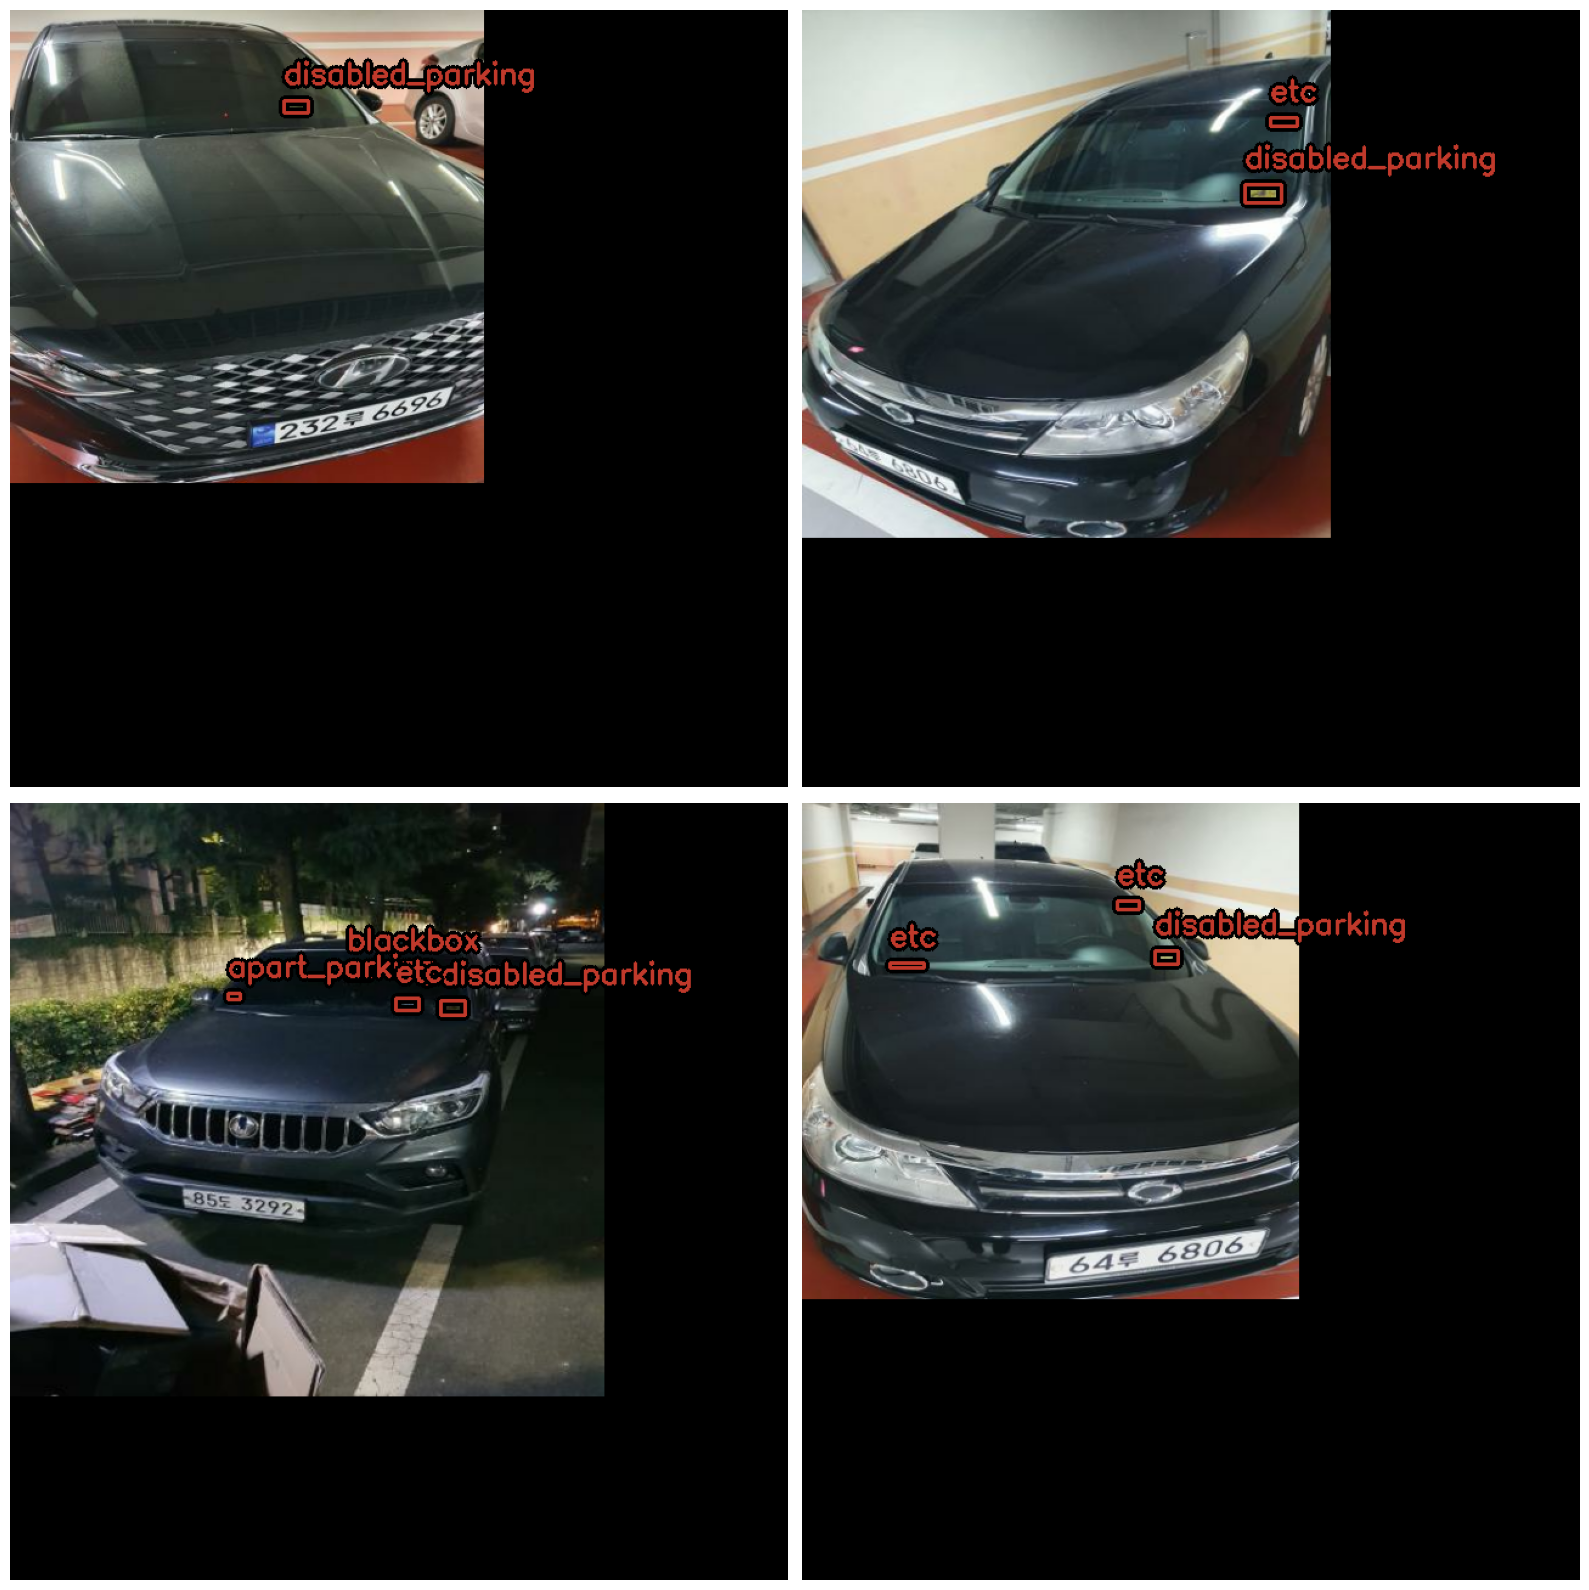

In [24]:
visualize_dataset(train_dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

In [25]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_m_backbone_coco")

100%|██████████| 646/646 [00:00<00:00, 1.22MB/s]
100%|██████████| 45.6M/45.6M [00:01<00:00, 37.6MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [26]:
YOLOV8_model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                              bounding_box_format="xyxy",
                                              backbone=backbone, fpn_depth=1)

optimizer = AdamW(learning_rate=0.001, weight_decay=0.004, global_clipnorm= GLOBAL_CLIPNORM)

YOLOV8_model.compile(optimizer = optimizer, classification_loss= 'binary_crossentropy', box_loss = 'ciou')

In [ ]:
hist = YOLOV8_model.fit(train_dataset, validation_data = valid_dataset, epochs = 80 )

Epoch 1/80
254/254 [==============================] - 5879s 23s/step - loss: 980.1083 - box_loss: 3.6980 - class_loss: 976.4099 - val_loss: 5.6183 - val_box_loss: 4.2760 - val_class_loss: 1.3423
Epoch 2/80
132/254 [==============>...............] - ETA: 46:15 - loss: 4.2045 - box_loss: 3.4815 - class_loss: 0.7230

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'][1:])
axs[0].plot(hist.history['val_loss'][1:])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Box Loss")
axs[1].plot(hist.history['box_loss'])
axs[1].plot(hist.history['val_box_loss'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Class Loss")
axs[2].plot(hist.history['class_loss'][1:])
axs[2].plot(hist.history['val_class_loss'][1:])
axs[2].legend(["train",  "validataion"])

In [ ]:
def visualize_predict_detections(model, dataset, bounding_box_format):
  images, y_true = next(iter(dataset.take(1)))

  y_pred = model.predict(images)
  y_pred = keras_cv.bounding_box.to_ragged(y_pred)

  keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color = (192, 57, 43),
        pred_color=(255, 235, 59),
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        rows=2,
        cols=2,
        show=True,
        class_mapping=class_mapping,
    )

In [ ]:
visualize_predict_detection(YOLOV8_model, dataset = test_dataset, boundling_box_format = "xyxy")